# Predicting Chronic Kidney Disease

### Definition
The data used in this investigation of chronic kidney disease is taken from a Kaggle dataset which was added by the Co-learning Lounge - https://www.kaggle.com/colearninglounge/chronic-kidney-disease, with acknowledgments to https://archive.ics.uci.edu/ml/datasets/Chronic_Kidney_Disease for the original data source.

The data has been taken over a two-month period in India, and includes 25 variables, mostly related to the patient's blood.

The target of this investigation is to determine whether or not the patient has chronic kidney disease.

A few models will be tried, starting with logistic regression since it is used to explain the relationship between one dependent binary variable (disease present or not) and one or more nominal, ordinal, interval or ratio-level independent variables.

### Load the appropriate libraries

In [237]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

# Importing Classifier Modules
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC, LinearSVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import Perceptron
from sklearn.linear_model import SGDClassifier
from sklearn.metrics import confusion_matrix


### Load the kidney disease data

In [176]:
df = pd.read_csv("kidney_disease_train.csv")
df_test = pd.read_csv("kidney_disease_test.csv")


In [177]:
df.head()

,id,age,bp,sg,al,su,rbc,pc,pcc,ba,...,pcv,wc,rc,htn,dm,cad,appet,pe,ane,classification
0,157,62.0,70.0,1.025,3.0,0.0,normal,abnormal,notpresent,notpresent,...,39.0,7900,3.9,yes,yes,no,good,no,no,ckd
1,109,54.0,70.0,NaN,NaN,NaN,NaN,NaN,notpresent,notpresent,...,NaN,NaN,NaN,no,yes,no,good,no,no,ckd
2,17,47.0,80.0,NaN,NaN,NaN,NaN,NaN,notpresent,notpresent,...,NaN,NaN,NaN,yes,no,no,poor,no,no,ckd
3,347,43.0,60.0,1.025,0.0,0.0,normal,normal,notpresent,notpresent,...,43.0,7200,5.5,no,no,no,good,no,no,notckd
4,24,42.0,100.0,1.015,4.0,0.0,normal,abnormal,notpresent,present,...,39.0,8300,4.6,yes,no,no,poor,no,no,ckd


In [178]:
df_test.head()

,id,age,bp,sg,al,su,rbc,pc,pcc,ba,...,hemo,pcv,wc,rc,htn,dm,cad,appet,pe,ane
0,209,19.0,70.0,1.020,0.0,0.0,NaN,normal,notpresent,notpresent,...,11.5,NaN,6900.0,NaN,no,no,no,good,no,no
1,280,47.0,80.0,NaN,NaN,NaN,NaN,NaN,notpresent,notpresent,...,13.3,52,8100.0,5.2,no,no,no,good,no,no
2,33,60.0,100.0,1.020,2.0,0.0,abnormal,abnormal,notpresent,notpresent,...,10.1,29,NaN,NaN,yes,no,no,poor,no,no
3,210,59.0,100.0,1.015,4.0,2.0,normal,normal,notpresent,notpresent,...,7.3,20,9800.0,3.9,yes,yes,yes,good,no,yes
4,93,73.0,100.0,1.010,3.0,2.0,abnormal,abnormal,present,notpresent,...,9.2,30,7000.0,3.2,yes,yes,yes,poor,no,no


### Analysis

In [179]:
len(df)


280

In [180]:
len(df_test)


120

There are 400 rows, where 70% are for training and 30% are for testing.

In [181]:
df.drop_duplicates()
df_test.drop_duplicates()
len(df)


280

In [182]:
len(df_test)


120

No duplicates are present

### Data types

In [183]:
df.dtypes

id                  int64
age               float64
bp                float64
sg                float64
al                float64
su                float64
rbc                object
pc                 object
pcc                object
ba                 object
bgr               float64
bu                float64
sc                float64
sod               float64
pot               float64
hemo              float64
pcv               float64
wc                 object
rc                 object
htn                object
dm                 object
cad                object
appet              object
pe                 object
ane                object
classification     object
dtype: object

### Check whether the target data is balanced
Does the patient have chronic kidney disease or not?

- ckd: Has chronic kidney disease
- notckd: Does not have chronic kidney disease

In [184]:
df.classification.value_counts()

ckd       174
notckd    106
Name: classification, dtype: int64

### Plot outliers for each numerical feature

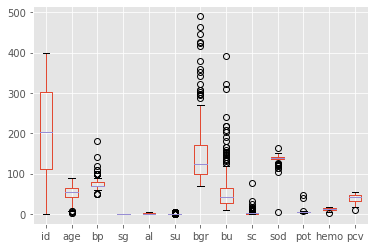

In [185]:
df.boxplot()


### Rename columns to clarify abbreviations and to show full names on plots

In [186]:
df = df.rename(columns={'bp': 'blood_pressure','sg': 'specific_gravity','al': 'albumin','su': 'sugar',
                   'rbc': 'red_blood_cells','pc': 'pus_cell','pcc': 'pus_cell_clumps','ba': 'bacteria',
                   'bgr': 'blood_glucose_random','bu': 'blood_urea','sc': 'serum_creatinine',
                   'sod': 'sodium','pot': 'potassium','hemo': 'hemoglobin','pcv': 'packed_cell_volume',
                   'wc': 'white_blood_cell','rc': 'red_blood_cell','htn': 'hypertension','dm': 'diabetes_mellitus',
                   'cad': 'coronary_artery_disease','appet': 'appetite','pe': 'pedal_edema','ane': 'anemia'})


### Coerce numerical values from string to float

In [187]:
df['white_blood_cell'] = pd.to_numeric(df['white_blood_cell'], errors='coerce')
df['red_blood_cell'] = pd.to_numeric(df['red_blood_cell'], errors='coerce')

### Create boolean values for each object feature

In [188]:
df.red_blood_cells = df.red_blood_cells.map({ 'normal' : 1, 'abnormal' : 0})
df.pus_cell = df.pus_cell.map({ 'normal' : 1, 'abnormal' : 0})
df.pus_cell_clumps = df.pus_cell_clumps.map({ 'present' : 1, 'notpresent' : 0})
df.bacteria = df.bacteria.map({ 'present' : 1, 'notpresent' : 0})
df.hypertension = df.hypertension.map({ 'yes' : 1, 'no' : 0})
df.diabetes_mellitus = df.diabetes_mellitus.map({ 'yes' : 1, '\tyes' : 1, '\tno' : 0, 'no' : 0})
df.coronary_artery_disease = df.coronary_artery_disease.map({ 'yes' : 1, 'no' : 0, '\tno' : 0})
df.appetite = df.appetite.map({ 'good' : 1, 'poor' : 0})
df.pedal_edema = df.pedal_edema.map({ 'yes' : 1, 'no' : 0})
df.anemia = df.anemia.map({ 'yes' : 1, 'no' : 0})
df.classification = df.classification.map({ 'ckd' : 1, 'notckd' : 0})

In [189]:
df.columns

Index(['id', 'age', 'blood_pressure', 'specific_gravity', 'albumin', 'sugar',
       'red_blood_cells', 'pus_cell', 'pus_cell_clumps', 'bacteria',
       'blood_glucose_random', 'blood_urea', 'serum_creatinine', 'sodium',
       'potassium', 'hemoglobin', 'packed_cell_volume', 'white_blood_cell',
       'red_blood_cell', 'hypertension', 'diabetes_mellitus',
       'coronary_artery_disease', 'appetite', 'pedal_edema', 'anemia',
       'classification'],
      dtype='object')

### Check how many null values are in the data set

In [190]:
df.isnull().sum()

id                           0
age                          5
blood_pressure               9
specific_gravity            36
albumin                     35
sugar                       38
red_blood_cells            107
pus_cell                    50
pus_cell_clumps              4
bacteria                     4
blood_glucose_random        33
blood_urea                  14
serum_creatinine            12
sodium                      67
potassium                   68
hemoglobin                  39
packed_cell_volume          51
white_blood_cell            78
red_blood_cell              94
hypertension                 1
diabetes_mellitus            1
coronary_artery_disease      1
appetite                     0
pedal_edema                  0
anemia                       0
classification               0
dtype: int64

In [191]:
df.describe()

,id,age,blood_pressure,specific_gravity,albumin,sugar,red_blood_cells,pus_cell,pus_cell_clumps,bacteria,...,packed_cell_volume,white_blood_cell,red_blood_cell,hypertension,diabetes_mellitus,coronary_artery_disease,appetite,pedal_edema,anemia,classification
count,280.000000,275.000000,271.000000,244.000000,245.000000,242.000000,173.000000,230.000000,276.000000,276.000000,...,229.000000,202.000000,186.000000,279.000000,279.000000,279.000000,280.000000,280.000000,280.000000,280.000000
mean,202.928571,51.454545,76.051661,1.017439,1.024490,0.438017,0.832370,0.786957,0.094203,0.057971,...,39.165939,8354.950495,4.706452,0.365591,0.362007,0.082437,0.778571,0.182143,0.142857,0.621429
std,111.988168,17.476176,14.256289,0.005746,1.375805,1.073193,0.374622,0.410351,0.292641,0.234113,...,8.774388,3107.125537,1.029280,0.482461,0.481444,0.275524,0.415952,0.386653,0.350554,0.485899
min,1.000000,2.000000,50.000000,1.005000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,9.000000,2200.000000,2.100000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,110.500000,42.000000,70.000000,1.010000,0.000000,0.000000,1.000000,1.000000,0.000000,0.000000,...,33.000000,6325.000000,3.925000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000
50%,202.000000,55.000000,70.000000,1.020000,0.000000,0.000000,1.000000,1.000000,0.000000,0.000000,...,41.000000,7900.000000,4.800000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,1.000000
75%,302.250000,65.000000,80.000000,1.020000,2.000000,0.000000,1.000000,1.000000,0.000000,0.000000,...,46.000000,9800.000000,5.500000,1.000000,1.000000,0.000000,1.000000,0.000000,0.000000,1.000000
max,399.000000,90.000000,180.000000,1.025000,5.000000,5.000000,1.000000,1.000000,1.000000,1.000000,...,54.000000,26400.000000,8.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


# Imputing Data
### Fill the null values with the median value of each column

The median is suitable as a fill for the NaN values since we have filled object-type columns with boolean values
so the median of each feature column will be used (instead of the mean).
Why? - IF we don't impute missing data we need to delete those rows, and we don't want to lose features like red_blood_cells which is missing 107 out of 280 values.

In [192]:
def fill_nans():
    """
    Fill the null values of each column with its median value
    created under new column names ending with '_filled'

    :return: A dataframe where the columns of data type float64 have their NaN values replaced
             with the median of each column under a new column name ending with '_filled'
    """        
    for col in df.columns:
        if df[col].dtype == 'float64':
            new_col = str(col + '_filled')
            df[new_col] = df[col].transform(lambda x: x.fillna(x.median()))
    return df

fill_nans()

,id,age,blood_pressure,specific_gravity,albumin,sugar,red_blood_cells,pus_cell,pus_cell_clumps,bacteria,...,serum_creatinine_filled,sodium_filled,potassium_filled,hemoglobin_filled,packed_cell_volume_filled,white_blood_cell_filled,red_blood_cell_filled,hypertension_filled,diabetes_mellitus_filled,coronary_artery_disease_filled
0,157,62.0,70.0,1.025,3.0,0.0,1.0,0.0,0.0,0.0,...,1.7,136.0,4.7,12.6,39.0,7900.0,3.9,1.0,1.0,0.0
1,109,54.0,70.0,NaN,NaN,NaN,NaN,NaN,0.0,0.0,...,1.9,138.0,4.4,11.7,41.0,7900.0,4.8,0.0,1.0,0.0
2,17,47.0,80.0,NaN,NaN,NaN,NaN,NaN,0.0,0.0,...,5.2,139.0,3.7,12.1,41.0,7900.0,4.8,1.0,0.0,0.0
3,347,43.0,60.0,1.025,0.0,0.0,1.0,1.0,0.0,0.0,...,1.0,144.0,5.0,17.8,43.0,7200.0,5.5,0.0,0.0,0.0
4,24,42.0,100.0,1.015,4.0,0.0,1.0,0.0,0.0,1.0,...,1.4,129.0,4.0,11.1,39.0,8300.0,4.6,1.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
275,71,46.0,60.0,1.010,1.0,0.0,1.0,1.0,0.0,0.0,...,3.3,141.0,4.0,9.8,28.0,14600.0,3.2,1.0,1.0,0.0
276,106,50.0,90.0,NaN,NaN,NaN,NaN,NaN,0.0,0.0,...,6.1,127.0,4.4,6.0,17.0,6500.0,4.8,1.0,1.0,0.0
277,270,23.0,80.0,1.025,0.0,0.0,1.0,1.0,0.0,0.0,...,1.1,145.0,4.0,14.3,41.0,7200.0,5.0,0.0,0.0,0.0
278,348,38.0,80.0,1.020,0.0,0.0,1.0,1.0,0.0,0.0,...,0.5,147.0,3.5,13.6,44.0,7300.0,6.4,0.0,0.0,0.0


### Re-check how many null values are in the data set

In [193]:
df.isnull().sum()

id                                  0
age                                 5
blood_pressure                      9
specific_gravity                   36
albumin                            35
sugar                              38
red_blood_cells                   107
pus_cell                           50
pus_cell_clumps                     4
bacteria                            4
blood_glucose_random               33
blood_urea                         14
serum_creatinine                   12
sodium                             67
potassium                          68
hemoglobin                         39
packed_cell_volume                 51
white_blood_cell                   78
red_blood_cell                     94
hypertension                        1
diabetes_mellitus                   1
coronary_artery_disease             1
appetite                            0
pedal_edema                         0
anemia                              0
classification                      0
age_filled  

### The new columns have no NaN values, so we'll drop the original columns and use the newly filled columns.
### A new dataframe will be created with the filled columns

In [194]:
# Drop columns which have not been filled
new_df = df.drop(columns=['age', 'blood_pressure', 'specific_gravity',
                          'albumin', 'sugar', 'red_blood_cells', 'pus_cell',
                          'pus_cell_clumps', 'bacteria','blood_glucose_random',
                          'blood_urea', 'serum_creatinine', 'sodium','potassium',
                          'hemoglobin', 'packed_cell_volume', 'white_blood_cell',
                          'red_blood_cell', 'hypertension', 'diabetes_mellitus',
                          'coronary_artery_disease'])

# Re-order columns to match the original df
new_df = new_df[['id', 'age_filled', 'blood_pressure_filled',
           'specific_gravity_filled', 'albumin_filled', 'sugar_filled',
           'red_blood_cells_filled', 'pus_cell_filled', 'pus_cell_clumps_filled',
           'bacteria_filled', 'blood_glucose_random_filled', 'blood_urea_filled',
           'serum_creatinine_filled', 'sodium_filled', 'potassium_filled',
           'hemoglobin_filled', 'packed_cell_volume_filled',
           'white_blood_cell_filled', 'red_blood_cell_filled',
           'hypertension_filled', 'diabetes_mellitus_filled',
           'coronary_artery_disease_filled','appetite',
           'pedal_edema', 'anemia','classification']]

### Find and remove outliers

An assumption of binary logistic regression is there should be no outliers in the data

In [195]:
def find_outliers(col):
    """
    Identify the outliers of each column of a dataframe using the Tukey rule

    :return: A dataframe of the outliers for each column
    """
    # Calculate the first quartile
    Q1 = df[col].quantile(.25)

    # Calculate the third quartile
    Q3 = df[col].quantile(.75)

    # Calculate the interquartile range Q3 - Q1
    IQR = Q3 - Q1
    IQR

    # Calculate the maximum value and minimum values according to the Tukey rule
    # max_value is Q3 + 1.5 * IQR while min_value is Q1 - 1.5 * IQR

    max_value = Q3 + 1.5 * IQR
    min_value = Q1 - 1.5 * IQR

    # Filter the training data for values that are greater than max_value or less than min_value
    outliers = df[(df[col] > max_value) | (df[col] < min_value)]
    return outliers


### We want to find outliers in each feature column except those with classification values
#### Let's identify features which are categorical by the value counts of each column

In [196]:
for col in new_df.columns:
    feat_count = len(new_df[col].value_counts())
    print('{}: {}'.format(col, feat_count))

id: 280
age_filled: 70
blood_pressure_filled: 10
specific_gravity_filled: 5
albumin_filled: 6
sugar_filled: 6
red_blood_cells_filled: 2
pus_cell_filled: 2
pus_cell_clumps_filled: 2
bacteria_filled: 2
blood_glucose_random_filled: 126
blood_urea_filled: 99
serum_creatinine_filled: 71
sodium_filled: 33
potassium_filled: 35
hemoglobin_filled: 102
packed_cell_volume_filled: 39
white_blood_cell_filled: 76
red_blood_cell_filled: 44
hypertension_filled: 2
diabetes_mellitus_filled: 2
coronary_artery_disease_filled: 2
appetite: 2
pedal_edema: 2
anemia: 2
classification: 2


### Non-Categorical
- 'age_filled', 
- 'blood_glucose_random_filled'
- 'blood_urea_filled'
- 'serum_creatinine_filled'
- 'hemoglobin_filled'
- 'white_blood_cell_filled'
- 'red_blood_cell_filled'
- 'blood_pressure_filled',
- 'sodium_filled'
- 'potassium_filled'
- 'packed_cell_volume_filled'


### Categorical
- 'specific_gravity_filled',
- 'albumin_filled',
- 'sugar_filled', 
- 'red_blood_cells_filled',
- 'pus_cell_filled', 
- 'pus_cell_clumps_filled', 
- 'bacteria_filled'
- 'hypertension_filled'
- 'diabetes_mellitus_filled',
- 'coronary_artery_disease_filled', 
- 'appetite', 
- 'pedal_edema', 
- 'anemia'

In [197]:
# Outliers to be removed for the logistic regression model
age_outliers = find_outliers('age_filled')
bgr_outliers = find_outliers('blood_glucose_random_filled')
bu_outliers = find_outliers('blood_urea_filled')
sc_outliers = find_outliers('serum_creatinine_filled')
hem_outliers = find_outliers('hemoglobin_filled')
wbc_outliers = find_outliers('white_blood_cell_filled')
rbc_outliers = find_outliers('red_blood_cell_filled')
bp_outliers = find_outliers('blood_pressure_filled')
sod_outliers = find_outliers('sodium_filled')
pot_outliers = find_outliers('potassium_filled')
pcv_outliers = find_outliers('packed_cell_volume_filled')

### Outliers to be removed for the logistic regression model
Merge outlier dfs and remove all rows from new_df in one go
Compile the list of dataframes to be merged

In [198]:
all_outliers = [age_outliers,
                bgr_outliers,
                bu_outliers,
                sc_outliers,
                hem_outliers,
                wbc_outliers,
                rbc_outliers,
                bp_outliers,
                sod_outliers,
                pot_outliers,
                pcv_outliers
                ]

In [199]:
df_outliers = pd.concat(all_outliers)

### Most outliers are classified as having chronic kidney disease
This could indicate the importance of keeping these patients in the dataset.

In [200]:
len(df_outliers)

224

In [201]:
len(df_outliers[df_outliers.classification == 1])

195

In [202]:
df_outliers.head()

,id,age,blood_pressure,specific_gravity,albumin,sugar,red_blood_cells,pus_cell,pus_cell_clumps,bacteria,...,serum_creatinine_filled,sodium_filled,potassium_filled,hemoglobin_filled,packed_cell_volume_filled,white_blood_cell_filled,red_blood_cell_filled,hypertension_filled,diabetes_mellitus_filled,coronary_artery_disease_filled
89,185,4.0,NaN,1.02,1.0,0.0,NaN,1.0,0.0,0.0,...,0.6,138.0,4.4,12.0,34.0,7900.0,4.8,0.0,0.0,0.0
169,215,2.0,NaN,1.01,3.0,0.0,1.0,0.0,0.0,0.0,...,1.3,138.0,4.4,12.7,41.0,7900.0,4.8,0.0,0.0,0.0
212,190,6.0,60.0,1.01,4.0,0.0,0.0,0.0,0.0,1.0,...,1.0,135.0,4.9,9.9,30.0,16700.0,4.8,0.0,0.0,0.0
217,1,7.0,50.0,1.02,4.0,0.0,NaN,1.0,0.0,0.0,...,0.8,138.0,4.4,11.3,38.0,6000.0,4.8,0.0,0.0,0.0
246,187,3.0,NaN,1.01,2.0,0.0,1.0,1.0,0.0,0.0,...,0.7,138.0,4.4,10.7,34.0,12300.0,4.8,0.0,0.0,0.0


### Create a dataframe with the outliers removed
A major assumption of using binary logistic regression is that there should be no outliers in the data

In [203]:
df_outliers_removed = new_df.drop(df_outliers.index).reset_index(drop=True)
len(df_outliers_removed)

153

### 127 rows are lost when we get rid of the outliers!
We'll try logistic regression but there won't be much data with which to run it.

### Let's use logistic regression on df_outliers_removed

### Check whether the target data is balanced
Does the patient have chronic kidney disease or not?

- ( 0 ) notckd:    Doesn't have the disease
- ( 1 ) ckd:      Has the disease

In [204]:
df_outliers_removed.classification.value_counts()

0    79
1    74
Name: classification, dtype: int64

#### With outliers removed the ratio of patients who have been classified as having chronic kidney disease or not is 74:79. The classification target is nicely balanced.

In [205]:
new_df.classification.value_counts()

1    174
0    106
Name: classification, dtype: int64

## Remove ids for the models

In [206]:
df_outliers_removed = df_outliers_removed.drop(columns=['id'])
new_df = new_df.drop(columns=['id'])
df_test = df_test.drop(columns=['id'])

## Correlations

### Create a heat map of df_outliers_removed
The results will be used to further check feature and target relationships

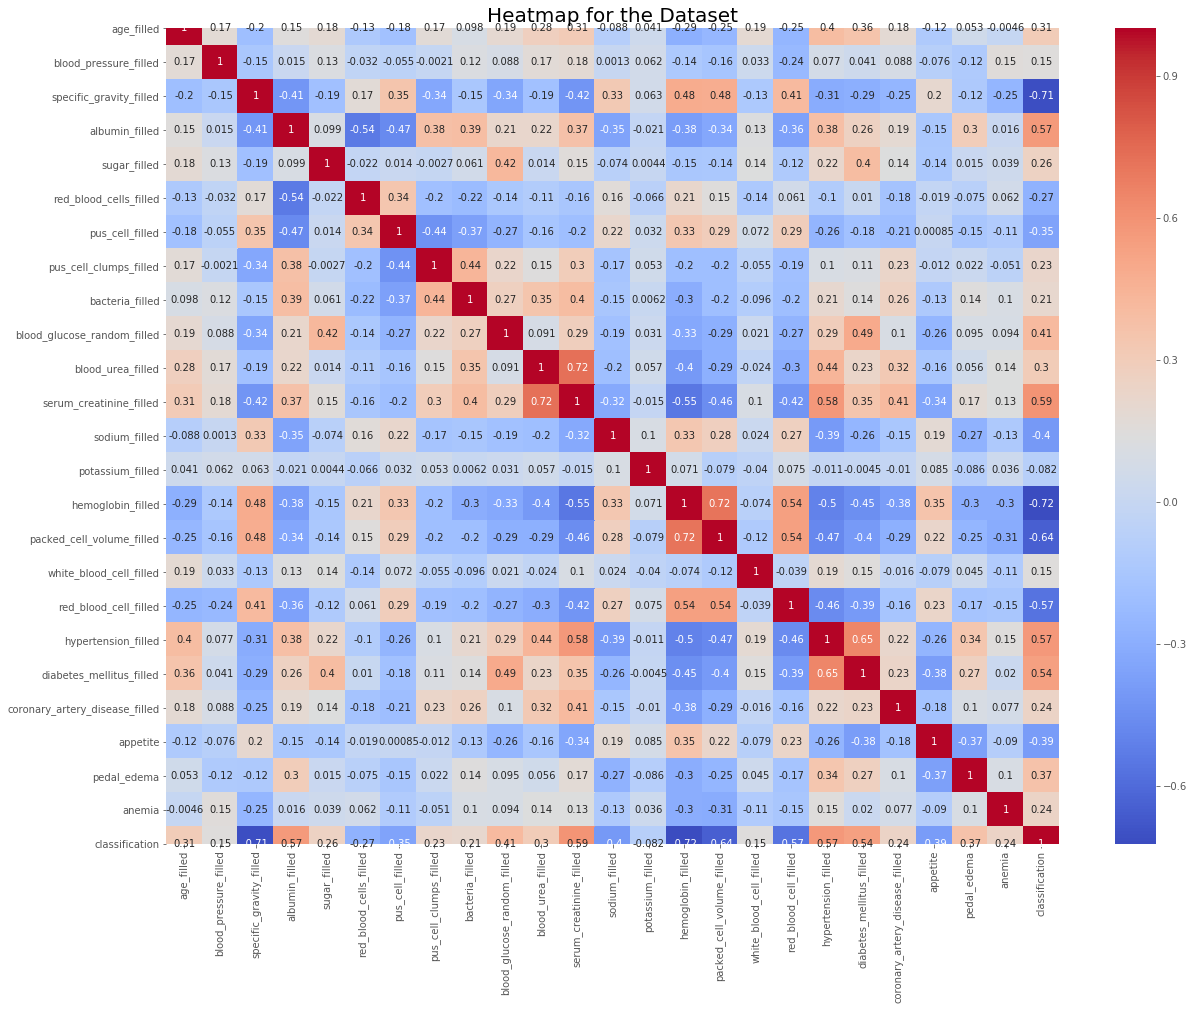

In [207]:
plt.rcParams['figure.figsize'] = (20, 15)
plt.style.use('ggplot')

sns.heatmap(df_outliers_removed.corr(), annot = True, cmap = 'coolwarm')
plt.title('Heatmap for the Dataset', fontsize = 20)
plt.show()

### Relationship between 'packed cell volume' and 'hemoglobin'

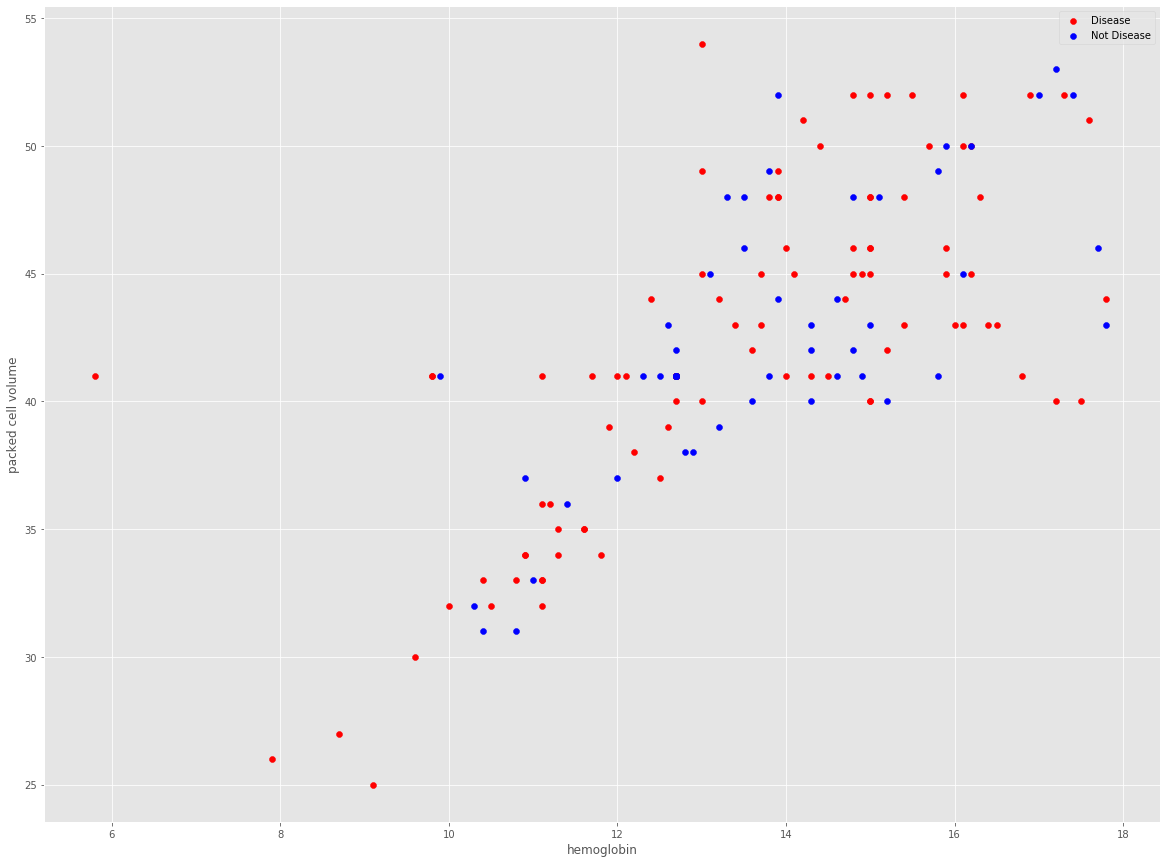

In [208]:
plt.scatter(x=df_outliers_removed.hemoglobin_filled[df.classification==1], y=df_outliers_removed.packed_cell_volume_filled[(df.classification==1)], c="red")
plt.scatter(x=df_outliers_removed.hemoglobin_filled[df.classification==0], y=df_outliers_removed.packed_cell_volume_filled[(df.classification==0)], c="blue")
plt.legend(["Disease", "Not Disease"])
plt.xlabel("hemoglobin")
plt.ylabel("packed cell volume")
plt.show()

The features 'packed cell volume' and 'hemoglobin' mostly correlate with each other.
PCV is the the volume percentage of red blood cells in blood.
Hemoglobin is a protein in your red blood cells that carries oxygen to your organs and tissues and transports carbon dioxide from your organs and tissues back to your lungs. Low hemoglobin levels means you have a low red blood cell count (anemia).

It makes sense that these show correlation as they both refer to the number of red blood cells in the blood.

### The relationship between 'serum creatinine' and the target

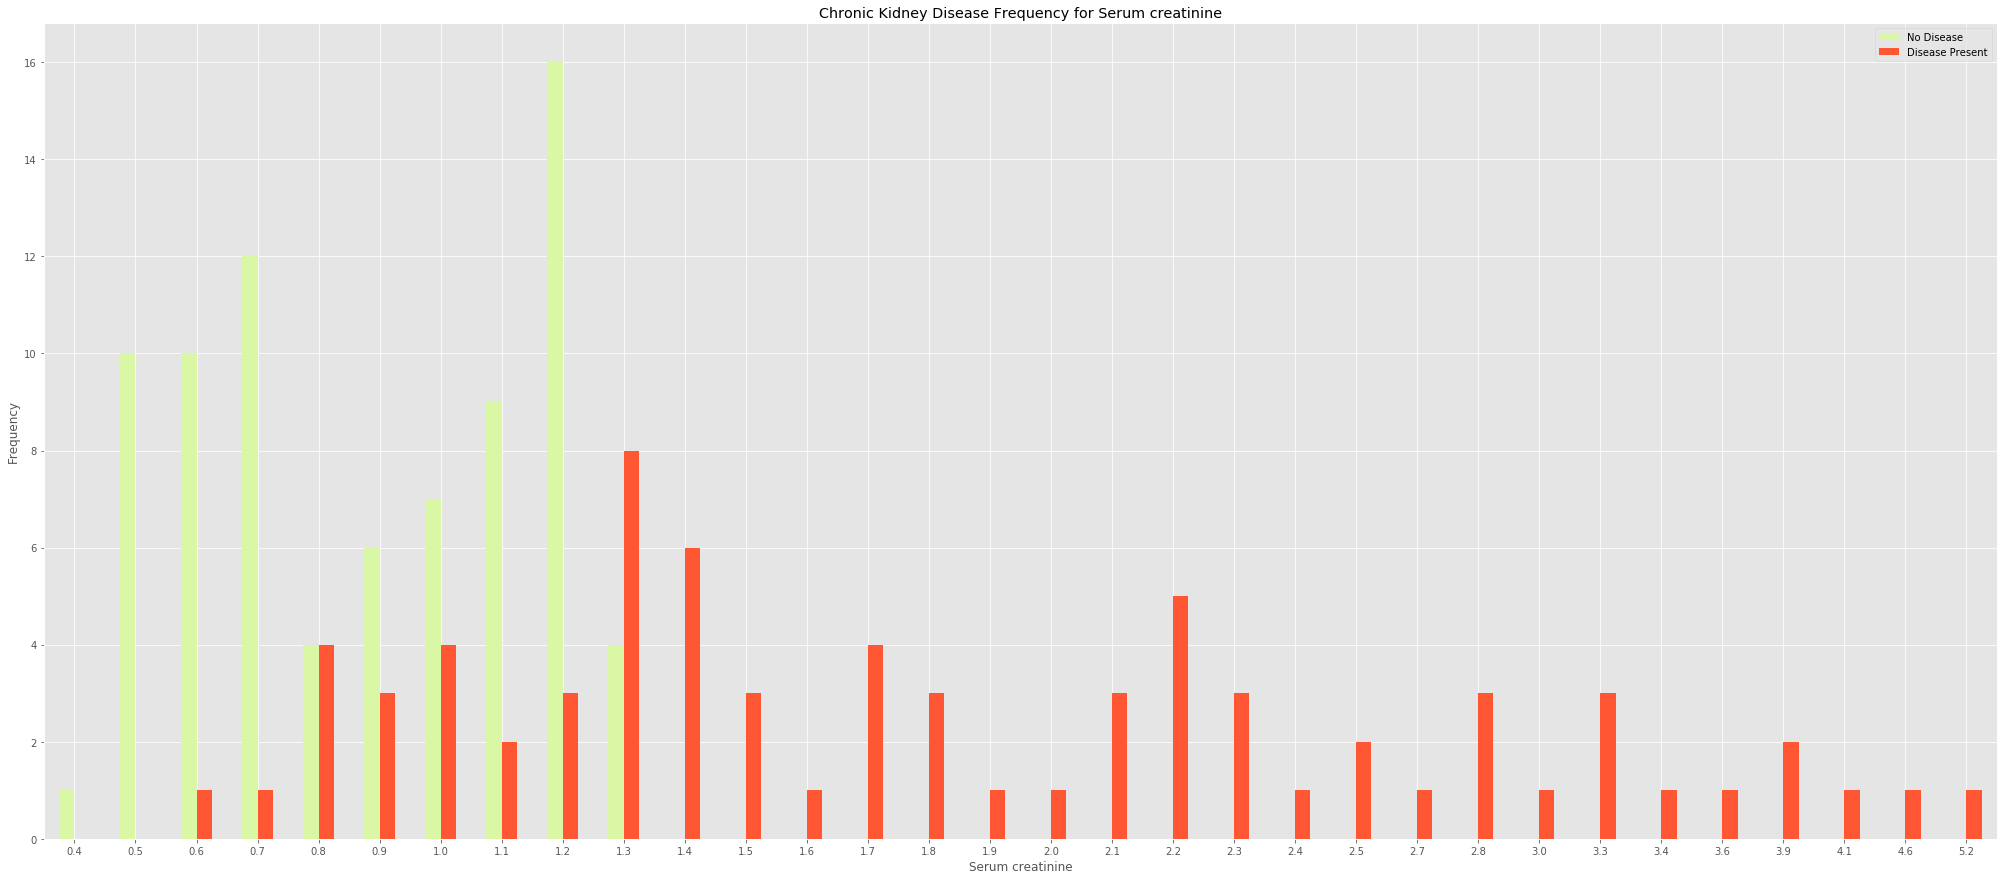

In [209]:
pd.crosstab(df_outliers_removed.serum_creatinine_filled,df_outliers_removed.classification).plot(kind="bar",figsize=(35,15),color=['#DAF7A6','#FF5733'])
plt.title('Chronic Kidney Disease Frequency for Serum creatinine')
plt.xlabel('Serum creatinine')
plt.xticks(rotation = 0)
plt.legend(["No Disease", "Disease Present"])
plt.ylabel('Frequency')
plt.show()

The feature 'serum creatine' most positively correlates with having chronic kidney disease, and this frequency plot shows that the lower the serum creatine the less likely you are to have chronic kidney disease.

### The relationship between 'Hemoglobin' and the target

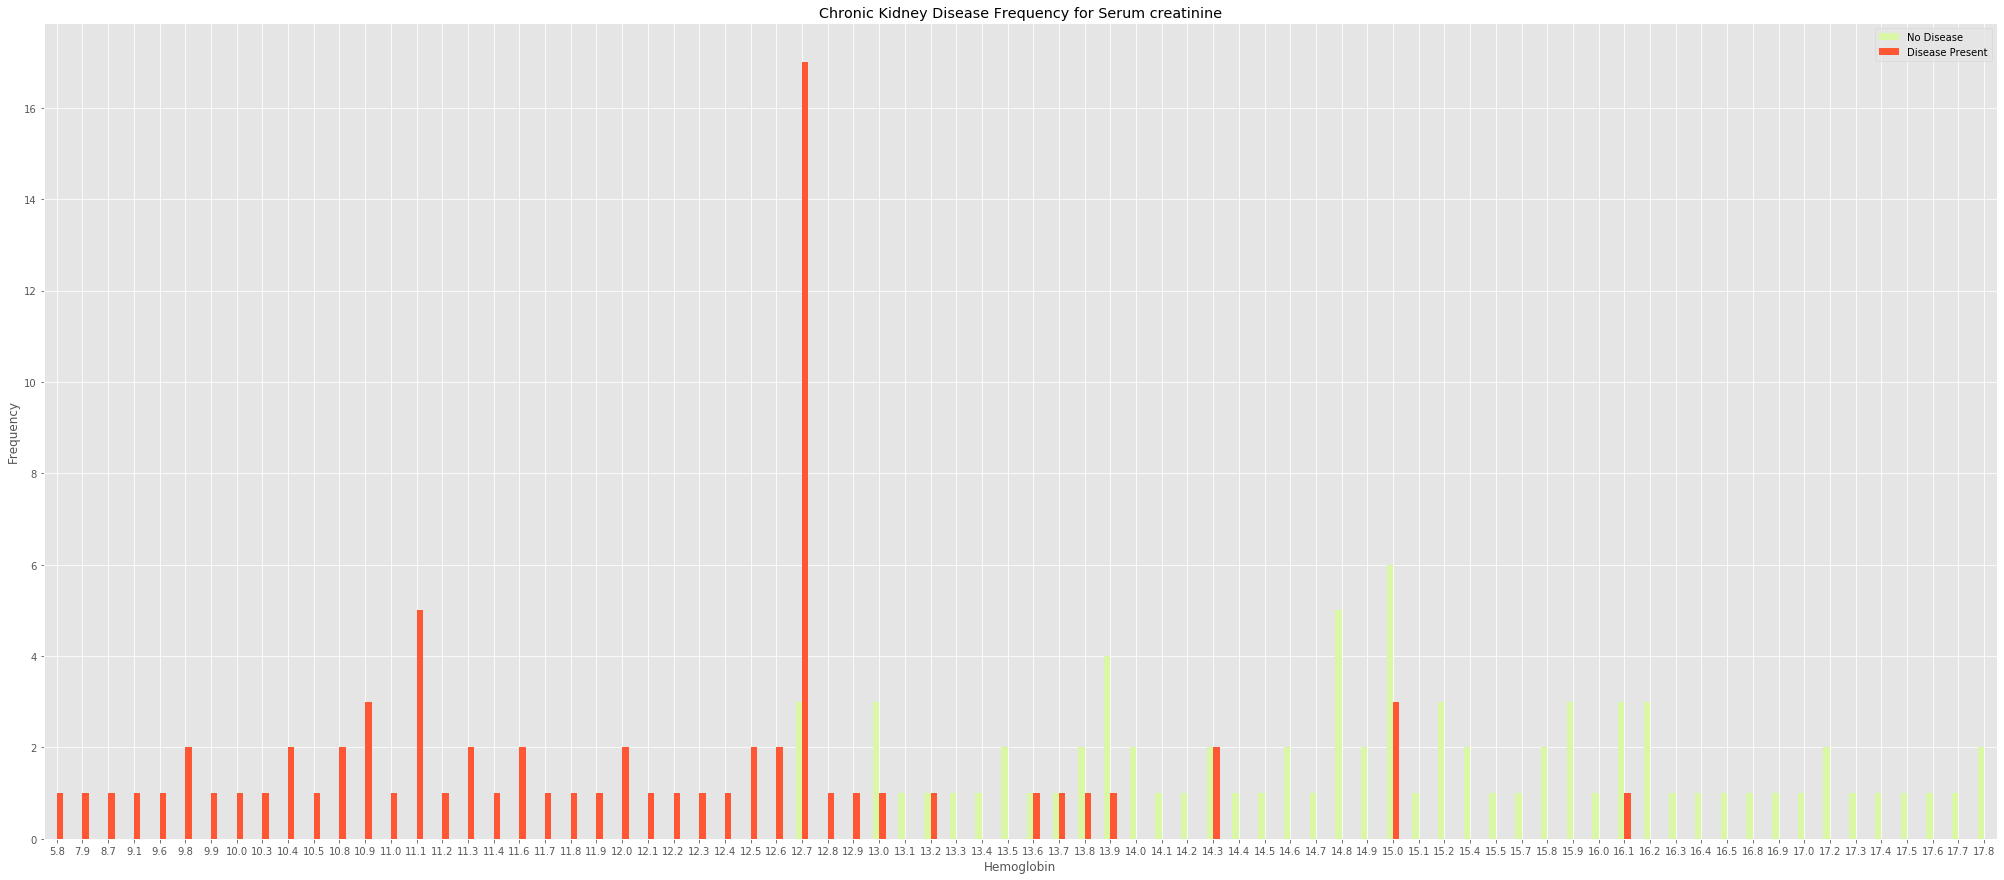

In [210]:
pd.crosstab(df_outliers_removed.hemoglobin_filled,df_outliers_removed.classification).plot(kind="bar",figsize=(35,15),color=['#DAF7A6','#FF5733'])
plt.title('Chronic Kidney Disease Frequency for Serum creatinine')
plt.xlabel('Hemoglobin')
plt.xticks(rotation = 0)
plt.legend(["No Disease", "Disease Present"])
plt.ylabel('Frequency')
plt.show()

The feature 'hemoglobin' most negatively correlates with having chronic kidney disease, and this frequency plot shows that the lower the hemoglobin the more likely you are to have chronic kidney disease.

### Tidy columns for modelling

In [211]:
df_test.columns

Index(['age', 'bp', 'sg', 'al', 'su', 'rbc', 'pc', 'pcc', 'ba', 'bgr', 'bu',
       'sc', 'sod', 'pot', 'hemo', 'pcv', 'wc', 'rc', 'htn', 'dm', 'cad',
       'appet', 'pe', 'ane'],
      dtype='object')

In [212]:
df_outliers_removed = df_outliers_removed.rename(columns={'age_filled': 'age',
                                                          'blood_pressure_filled': 'bp',
                                                          'specific_gravity_filled': 'sg',
                                                          'albumin_filled': 'al',
                                                          'sugar_filled': 'su',
                                                          'red_blood_cells_filled': 'rbc',
                                                          'pus_cell_filled': 'pc',
                                                          'pus_cell_clumps_filled': 'pcc',
                                                          'bacteria_filled': 'ba',
                                                          'blood_glucose_random_filled': 'bgr',
                                                          'blood_urea_filled': 'bu',
                                                          'serum_creatinine_filled': 'sc',
                                                          'sodium_filled': 'sod',
                                                          'potassium_filled': 'pot',
                                                          'hemoglobin_filled': 'hemo',
                                                          'packed_cell_volume_filled': 'pcv',
                                                          'white_blood_cell_filled': 'wc',
                                                          'red_blood_cell_filled': 'rc',
                                                          'hypertension_filled': 'htn',
                                                          'diabetes_mellitus_filled': 'dm',
                                                          'coronary_artery_disease_filled': 'cad',
                                                          'appetite': 'appet',
                                                          'pedal_edema': 'pe',
                                                          'anemia': 'ane'})

In [213]:
df_outliers_removed.columns

Index(['age', 'bp', 'sg', 'al', 'su', 'rbc', 'pc', 'pcc', 'ba', 'bgr', 'bu',
       'sc', 'sod', 'pot', 'hemo', 'pcv', 'wc', 'rc', 'htn', 'dm', 'cad',
       'appet', 'pe', 'ane', 'classification'],
      dtype='object')

In [214]:
df_outliers_removed.head()

,age,bp,sg,al,su,rbc,pc,pcc,ba,bgr,...,pcv,wc,rc,htn,dm,cad,appet,pe,ane,classification
0,62.0,70.0,1.025,3.0,0.0,1.0,0.0,0.0,0.0,122.0,...,39.0,7900.0,3.9,1.0,1.0,0.0,1,0,0,1
1,54.0,70.0,1.020,0.0,0.0,1.0,1.0,0.0,0.0,233.0,...,41.0,7900.0,4.8,0.0,1.0,0.0,1,0,0,1
2,47.0,80.0,1.020,0.0,0.0,1.0,1.0,0.0,0.0,114.0,...,41.0,7900.0,4.8,1.0,0.0,0.0,0,0,0,1
3,43.0,60.0,1.025,0.0,0.0,1.0,1.0,0.0,0.0,108.0,...,43.0,7200.0,5.5,0.0,0.0,0.0,1,0,0,0
4,29.0,80.0,1.020,0.0,0.0,1.0,1.0,0.0,0.0,83.0,...,40.0,9900.0,4.7,0.0,0.0,0.0,1,0,0,0


### Prepare test data

In [215]:
df_test.head()

,age,bp,sg,al,su,rbc,pc,pcc,ba,bgr,...,hemo,pcv,wc,rc,htn,dm,cad,appet,pe,ane
0,19.0,70.0,1.020,0.0,0.0,NaN,normal,notpresent,notpresent,NaN,...,11.5,NaN,6900.0,NaN,no,no,no,good,no,no
1,47.0,80.0,NaN,NaN,NaN,NaN,NaN,notpresent,notpresent,93.0,...,13.3,52,8100.0,5.2,no,no,no,good,no,no
2,60.0,100.0,1.020,2.0,0.0,abnormal,abnormal,notpresent,notpresent,140.0,...,10.1,29,NaN,NaN,yes,no,no,poor,no,no
3,59.0,100.0,1.015,4.0,2.0,normal,normal,notpresent,notpresent,255.0,...,7.3,20,9800.0,3.9,yes,yes,yes,good,no,yes
4,73.0,100.0,1.010,3.0,2.0,abnormal,abnormal,present,notpresent,295.0,...,9.2,30,7000.0,3.2,yes,yes,yes,poor,no,no


In [216]:
df_test.isnull().sum()

age       4
bp        3
sg       11
al       11
su       11
rbc      45
pc       15
pcc       0
ba        0
bgr      11
bu        5
sc        5
sod      20
pot      20
hemo     13
pcv      19
wc       28
rc       37
htn       1
dm        1
cad       1
appet     1
pe        1
ane       1
dtype: int64

There are 45 rows with missing red blood cells values, and 37 rows with missing red blood cell values.

In [217]:
df_test.dtypes

age      float64
bp       float64
sg       float64
al       float64
su       float64
rbc       object
pc        object
pcc       object
ba        object
bgr      float64
bu       float64
sc       float64
sod      float64
pot      float64
hemo     float64
pcv       object
wc       float64
rc       float64
htn       object
dm        object
cad       object
appet     object
pe        object
ane       object
dtype: object

### Create boolean values for each object feature in df_test

In [218]:
df_test.rbc = df_test.rbc.map({ 'normal' : 1, 'abnormal' : 0})
df_test.pc = df_test.pc.map({ 'normal' : 1, 'abnormal' : 0})
df_test.pcc = df_test.pcc.map({ 'present' : 1, 'notpresent' : 0})
df_test.ba = df_test.ba.map({ 'present' : 1, 'notpresent' : 0})
df_test.htn = df_test.htn.map({ 'yes' : 1, 'no' : 0})
df_test.dm = df_test.dm.map({ 'yes' : 1, '\tyes' : 1, '\tno' : 0, 'no' : 0})
df_test.cad = df_test.cad.map({ 'yes' : 1, 'no' : 0, '\tno' : 0})
df_test.appet = df_test.appet.map({ 'good' : 1, 'poor' : 0})
df_test.pe = df_test.pe.map({ 'yes' : 1, 'no' : 0})
df_test.ane = df_test.ane.map({ 'yes' : 1, 'no' : 0})

### Convert pcv feature from an object to a float in order to impute values in the next step

In [219]:
df_test.pcv = pd.to_numeric(df_test.pcv, errors='coerce')

# Imputing Data
### Fill the null values with the median value of each column

We will fill in NaN values with the median of each feature column like in the training data.

In [220]:
def fill_nans_test():
    """
    Fill the null values of each column with its median value

    :return: A dataframe where the columns of data type float64 have their NaN values replaced
             with the median of the column
    """ 
    for col in df_test.columns:
        if df_test[col].dtype == 'float64':
            df_test[col] = df_test[col].transform(lambda x: x.fillna(x.median()))
    return df_test

fill_nans_test()

,age,bp,sg,al,su,rbc,pc,pcc,ba,bgr,...,hemo,pcv,wc,rc,htn,dm,cad,appet,pe,ane
0,19.0,70.0,1.020,0.0,0.0,1.0,1.0,0,0,113.0,...,11.5,40.0,6900.0,4.8,0.0,0.0,0.0,1.0,0.0,0.0
1,47.0,80.0,1.020,0.0,0.0,1.0,1.0,0,0,93.0,...,13.3,52.0,8100.0,5.2,0.0,0.0,0.0,1.0,0.0,0.0
2,60.0,100.0,1.020,2.0,0.0,0.0,0.0,0,0,140.0,...,10.1,29.0,8300.0,4.8,1.0,0.0,0.0,0.0,0.0,0.0
3,59.0,100.0,1.015,4.0,2.0,1.0,1.0,0,0,255.0,...,7.3,20.0,9800.0,3.9,1.0,1.0,1.0,1.0,0.0,1.0
4,73.0,100.0,1.010,3.0,2.0,0.0,0.0,1,0,295.0,...,9.2,30.0,7000.0,3.2,1.0,1.0,1.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
115,67.0,90.0,1.020,1.0,0.0,1.0,0.0,1,0,141.0,...,12.6,40.0,8300.0,4.8,1.0,0.0,0.0,1.0,0.0,0.0
116,56.0,80.0,1.010,1.0,0.0,1.0,1.0,0,0,165.0,...,13.5,40.0,11800.0,5.0,1.0,1.0,0.0,0.0,1.0,0.0
117,66.0,70.0,1.020,0.0,0.0,1.0,1.0,0,0,94.0,...,16.0,41.0,5300.0,5.9,0.0,0.0,0.0,1.0,0.0,0.0
118,41.0,80.0,1.020,0.0,0.0,1.0,1.0,0,0,122.0,...,17.1,41.0,9100.0,5.2,0.0,0.0,0.0,1.0,0.0,0.0


In [221]:
df_test.isnull().sum()

age      0
bp       0
sg       0
al       0
su       0
rbc      0
pc       0
pcc      0
ba       0
bgr      0
bu       0
sc       0
sod      0
pot      0
hemo     0
pcv      0
wc       0
rc       0
htn      0
dm       0
cad      0
appet    0
pe       0
ane      0
dtype: int64

## The classification column is not present in test data. We have to train our classifier using the train data and generate predictions (classification of chronic kidney disease) on the test data.

In [222]:
X_train = df_outliers_removed.drop('classification', axis=1)
y_train = df_outliers_removed['classification']

In [223]:
X_test = df_test.copy()

In [224]:
X_train.shape, y_train.shape, X_test.shape

((153, 24), (153,), (120, 24))

### There are many classifying algorithms, and from these the following will be used for this investigation:

- Logistic Regression
- Support Vector Machines (SVC)
- Linear SVC
- k-Nearest Neighbor (KNN)
- Decision Tree
- Random Forest
- Naive Bayes (GaussianNB)
- Perceptron
- Stochastic Gradient Descent (SGD)

The training and testing methodology:

- Train a range of classifiers with the training data.
- Predict chronic kidney disease of the test data using the trained classifier.
- Calculate the accuracy score (in percentange) of the trained classifier.

Please note: that the accuracy score is generated based on our training dataset.

### Logistic Regression
This will be the starting point in the models used since assumptions made in the feature engineering suit this algorithm. For instance, the dependent variable should be dichotomous in nature (presence/absence).
In binary logistic regression there should be no outliers in the data.
There should be no high correlations among the predictors.

In [ ]:
def build_model():
    pipeline = Pipeline([
        ('clf', RandomForestClassifier())
    ])

    parameters = {
        'features__pipeline__vect__ngram_range': ((1, 1), (1, 2)),
        'features__pipeline__vect__max_df': (0.5, 0.75, 1.0),
        'features__pipeline__vect__max_features': (None, 5000, 10000),
        'features__pipeline__tfidf__use_idf': (True, False),
        'clf__n_estimators': [50, 100, 200],
        'clf__min_samples_split': [2, 3, 4]
    }

    cv = GridSearchCV(pipeline, param_grid=parameters)

    return cv

In [242]:

from sklearn.preprocessing import StandardScaler

pipeline = Pipeline([
    ('clf', LogisticRegression())
])


    "pipeline = Pipeline([\n",
    "    ('scaler', StandardScaler()),\n",
    "    ('clf', RandomForestClassifier())\n",
    "])"

    "pipeline.get_params().keys()


parameters = {
    'clf__max_iter': [100, 1000, 2000, 5000],
    'clf__fit_intercept': [True, False],
    'clf__penalty': ['l1', 'l2', 'elasticnet', 'none']
}

cv = GridSearchCV(pipeline, param_grid=parameters)

cv.fit(X_train, y_train)
y_pred = cv.predict(X_test)

/Users/helenbatson/.pyenv/versions/3.6.6/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:552: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/helenbatson/.pyenv/versions/3.6.6/lib/python3.6/site-packages/sklearn/model_selection/_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/helenbatson/.pyenv/versions/3.6.6/lib/python3.6/site-packages/sklearn/pipeline.py", line 335, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "/Users/helenbatson/.pyenv/versions/3.6.6/lib/python3.6/site-packages/sklearn/linear_model/_logistic.py", line 1304, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "/Users/helenbatson/.pyenv/versions/3.6.6/lib/python3.6/site-packages/sklearn/linear_model/_logistic.py", line 443, in _check_solver
    "got %s p

In [225]:
clf = LogisticRegression(max_iter=5000)
clf.fit(X_train, y_train)
y_pred_log_reg = clf.predict(X_test)
acc_log_reg = round( clf.score(X_train, y_train) * 100, 2)
print (str(acc_log_reg) + ' percent')

98.69 percent


### Support Vector Machine (SVM)

In [226]:
clf = SVC()
clf.fit(X_train, y_train)
y_pred_svc = clf.predict(X_test)
acc_svc = round(clf.score(X_train, y_train) * 100, 2)
print (acc_svc)

62.09


### Linear SVM
Linear SVM is an SVM model with a linear kernel.
LinearSVC stands for Linear Support Vector Classification.

In [233]:
clf = LinearSVC(max_iter=400000)
clf.fit(X_train, y_train)
y_pred_linear_svc = clf.predict(X_test)
acc_linear_svc = round(clf.score(X_train, y_train) * 100, 2)
print (acc_linear_svc)

81.05


/Users/helenbatson/.pyenv/versions/3.6.6/lib/python3.6/site-packages/sklearn/svm/_base.py:977: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


LinearSVC scored best with a max_iter of 400000. This is more time intensive than the default of 1000.

### Decision Tree

In [228]:
clf = DecisionTreeClassifier()
clf.fit(X_train, y_train)
y_pred_decision_tree = clf.predict(X_test)
acc_decision_tree = round(clf.score(X_train, y_train) * 100, 2)
print (acc_decision_tree)

100.0


### Random Forest

In [229]:
clf = RandomForestClassifier(n_estimators=100)
clf.fit(X_train, y_train)
y_pred_random_forest = clf.predict(X_test)
acc_random_forest = round(clf.score(X_train, y_train) * 100, 2)
print (acc_random_forest)

100.0


### Gaussian Naive Bayes

In [230]:
clf = GaussianNB()
clf.fit(X_train, y_train)
y_pred_gnb = clf.predict(X_test)
acc_gnb = round(clf.score(X_train, y_train) * 100, 2)
print (acc_gnb)

94.77


### Confusion Matrix

Accuracy: 100 % 

Confusion Matrix in Numbers
[[79  0]
 [ 0 74]]

Confusion Matrix in Percentage
[[1. 0.]
 [0. 1.]]



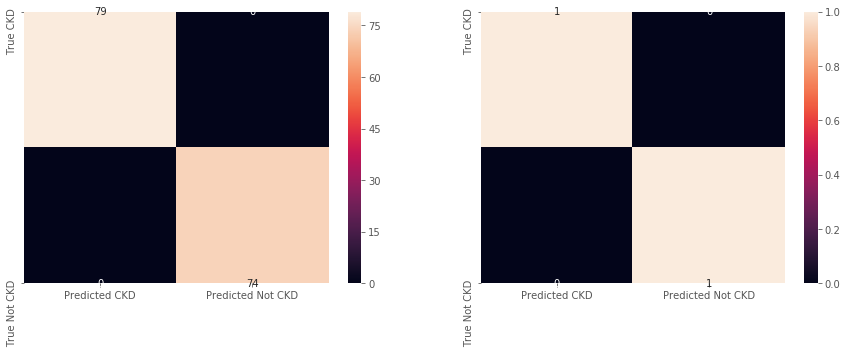

In [231]:
clf = RandomForestClassifier(n_estimators=100)
clf.fit(X_train, y_train)
y_pred_random_forest_training_set = clf.predict(X_train)
acc_random_forest = round(clf.score(X_train, y_train) * 100, 2)
print ("Accuracy: %i %% \n"%acc_random_forest)

class_names = ['Chronic Kidney Disease', 'No Chronic Kidney Disease']

# Compute confusion matrix
cnf_matrix = confusion_matrix(y_train, y_pred_random_forest_training_set)
np.set_printoptions(precision=2)

print ('Confusion Matrix in Numbers')
print (cnf_matrix)
print ('')

cnf_matrix_percent = cnf_matrix.astype('float') / cnf_matrix.sum(axis=1)[:, np.newaxis]

print ('Confusion Matrix in Percentage')
print (cnf_matrix_percent)
print ('')

true_class_names = ['True CKD', 'True Not CKD']
predicted_class_names = ['Predicted CKD', 'Predicted Not CKD']

df_cnf_matrix = pd.DataFrame(cnf_matrix, 
                             index = true_class_names,
                             columns = predicted_class_names)

df_cnf_matrix_percent = pd.DataFrame(cnf_matrix_percent, 
                                     index = true_class_names,
                                     columns = predicted_class_names)

plt.figure(figsize = (15,5))

plt.subplot(121)
sns.heatmap(df_cnf_matrix, annot=True, fmt='d')

plt.subplot(122)
sns.heatmap(df_cnf_matrix_percent, annot=True)

### Comparing Models
Let's compare the accuracy score of all the classifier models used above.

In [232]:
models = pd.DataFrame({
    'Model': ['Logistic Regression', 'Support Vector Machines', 'Linear SVC', 
              'Decision Tree', 'Random Forest', 'Naive Bayes'],
    
    'Score': [acc_log_reg, acc_svc, acc_linear_svc, 
              acc_decision_tree, acc_random_forest, acc_gnb]
    })

models.sort_values(by='Score', ascending=False)

,Model,Score
3,Decision Tree,100.00
4,Random Forest,100.00
0,Logistic Regression,98.69
5,Naive Bayes,94.77
2,Linear SVC,85.62
1,Support Vector Machines,62.09


### Justification: Final Model Chosen

From the above table, we can see that Decision Tree and Random Forest classfiers have the highest accuracy score.

Among these two, the Random Forest classifier is a better choice as it has the ability to limit overfitting when compared to the Decision Tree classifier.

### Conclusion

Chronic kidney disease can be predicted 100% from the provided dataset using the Random Forest Classifier.

The feature most correlated to this prediction is serum creatinine, which makes sense as healthy kidneys are known to filter creatinine and other waste products from our blood.

#### Reflections
The Random Forest and Decision tree classifiers performed best in the group of models used to predict chronic kidney disease from patient data. They both provided 100% accuracy.

Removing the outliers needed some reflection as a few variables were categorical and it did not make sense to remove some of those categories. Some careful consideration was required and it paid off in the performance of the logistic regression. However in the end that was not the best model as I expected. The Random Forest classifier was best due to it's ability to limit overfitting.

#### Improvements
There was not much open data found for kidney disease, but if it was found in abundance then the chosen model may change due to considerations of time performance, and more parameters would be tested to ensure the performance was optimal.